# Backtesting SPY call spreads

We will be trading spy bull call spreads, that is buying an at-the-money call and selling a further out-of-the-money call.

The strategy is profitable if the stock trades higher than the lower strike by more than the amount we paid for the spread (breakeven point).
We will buy 10 contracts of each leg and exit the trade after 5 days or when change in trend is detected.

We assume no slippage and commission of 1 dollar for option trades.


**Note**
<br>
For legal reasons, i cannot add ibkr historical data to this repository. If you got IBKR market subsriptions, you can extract it yourself, or use some other market data sources.


In [1]:
import math
import datetime
import numpy as np
import pandas as pd
from types import SimpleNamespace

import pyqstrat as pq

pq.set_defaults()
_logger = pq.get_child_logger('pyqstrat')

In [2]:
prices = pd.read_csv("./SPY_data.csv") 
imp_vol = pd.read_csv("./SPY_implied_vol.csv") 

In [3]:
def sma(contract_group, timestamps, indicators, strategy_context): # simple moving average
    sma = pd.Series(indicators.c).rolling(window = strategy_context.lookback_period).mean()
    return sma.values

strategy_context = SimpleNamespace(lookback_period = 50)

timestamps = prices.date.values.astype('M8[s]')
close_prices = prices.c.values

strategy_context.timestamps = timestamps
strategy_context.close_prices = close_prices

calendar = pq.Calendar.get_calendar(pq.Calendar.NYSE)
strategy_context.calendar = calendar
stock_symbol = 'SPY'
strategy_context.stock_symbol = stock_symbol

contract_group = pq.ContractGroup.create('spread')
contract = pq.Contract.create('SPY', contract_group)

indicators = SimpleNamespace(o = prices.o, h = prices.h, l = prices.l, c = prices.c)

sma_values = sma(contract, timestamps, indicators, strategy_context) 
indicators.sma = sma_values
indicators.implied_vol = imp_vol.c

Let's say we want to enter when price > sma, as buying call spread is bullish trade.  

<Figure size 800x600 with 0 Axes>

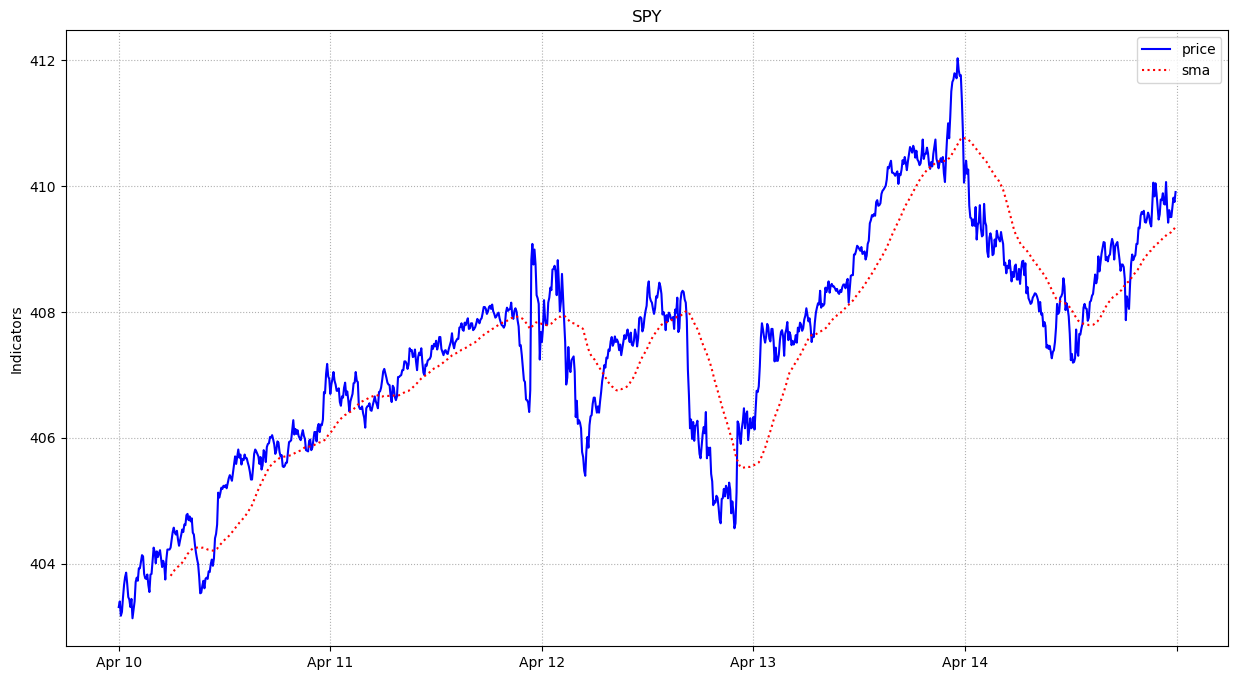

In [4]:
indicator_subplot = pq.Subplot(
    [pq.TimeSeries('price', timestamps[:1000], prices.c[:1000], display_attributes=pq.LinePlotAttributes(color = 'blue')), 
     pq.TimeSeries('sma', timestamps[:1000], sma_values[:1000], display_attributes=pq.LinePlotAttributes(line_type = 'dotted', color = 'red')),
    
    ],
    ylabel = 'Indicators')
plot = pq.Plot(indicator_subplot, title = 'SPY', show_date_gaps = False)
plot.draw();

I don't use volatility indicators as signals here, although it can also be incorporated into strategy.

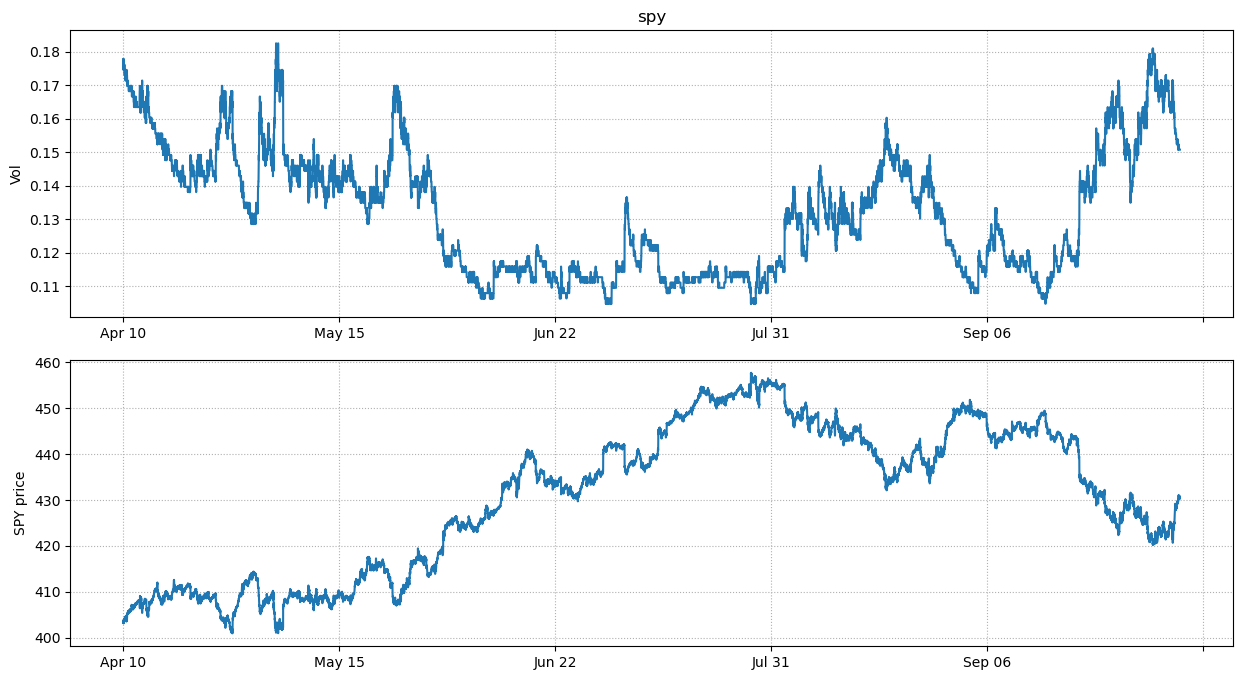

In [5]:
vol_subplot = pq.Subplot([pq.TimeSeries('imp_vol', timestamps, imp_vol.c)], ylabel = 'Vol')
price_subplot = pq.Subplot([pq.TimeSeries('spy', timestamps, prices.c)], ylabel = 'SPY price')
plot = pq.Plot([vol_subplot, price_subplot], title = 'spy')
plot.draw();

As expected, there is inverse relationship with price and volatility.  

Now we generate strikes and expiries.

In [6]:
strikes = np.arange(prices.c.min() - 20, prices.c.max() + 20, 1)
# Round strikes down to the nearest $5
strikes = np.round(strikes)
strategy_context.strikes = strikes

In [7]:
expiries = []
for i in range(4,12):    
    expiries.append(calendar.third_friday_of_month(i, 2023).astype('M8[s]') + np.timedelta64(16, 'h'))

strategy_context.expiries = expiries  

In [8]:
stock_prices = {}
# # Also store underlying prices in a dict for easy retrieval later
for i, timestamp in enumerate(timestamps):
    stock_prices[timestamp] = close_prices[i]
    
strategy_context.stock_prices = stock_prices

Options data is notoriously hard to handle due to it size and complexity, even though i don't take greeks into account here. I slightly modified the function from pyqstrat example notebooks, so we can calculate option prices on the fly, instead of precalculating and storing it.

In [9]:
def get_stock_price(symbol, timestamp, context):
    stock_prices = context.stock_prices
    return stock_prices.get(timestamp)

option_prices = {}
option_deltas = {}
symbols = []

def get_price(contract, timestamps, i, context):
    timestamp = timestamps[i]
    price = np.nan
    close_price = context.stock_prices[timestamp]
    symbol = contract.symbol     
    t = (contract.expiry - timestamp) / np.timedelta64(1, 'D') / 365.0  # Time to expiry as fraction of a year   
    symbols.append(symbol)
    option_price = pq.black_scholes_price(True, S = close_price, 
                                          K = contract.properties.strike, t = t, r = 0.02, 
                                          sigma = imp_vol.c[i], q = 0)
    option_prices[(symbol, timestamp)] = option_price
    delta = pq.delta(True, S = close_price, K = contract.properties.strike, t = t, r = 0.02,
                     sigma = imp_vol.c[i], q = 0)
    option_deltas[(symbol, timestamp)] = delta
    
    assert option_price is not None and math.isfinite(option_price), f'Bad option price: {price} {contract} {timestamps[i]}'
    
    return option_price

Now we write entry and exit signals, with changepoints that we find with BOCD.  

In [10]:
differenced = prices['c'].diff(1).copy(deep = False)
prices['diff'] = differenced
prices['diff'] = prices['diff'].fillna(0)*100
prices.head()

,Unnamed: 0,date,o,h,l,c,v,diff
0,0,2023-04-10 09:30:00,403.6709,403.9092,403.3036,403.3135,904969,0
1,1,2023-04-10 09:32:00,403.3036,403.4326,403.1547,403.4029,463724,0.0894
2,2,2023-04-10 09:34:00,403.3929,403.4724,403.0653,403.1745,526619,-0.2284
3,3,2023-04-10 09:36:00,403.1745,403.3334,403.0455,403.2341,503600,0.0596
4,4,2023-04-10 09:38:00,403.2142,403.4724,403.0752,403.4624,491287,0.2283


In [12]:
from utils.bocd import BOCD, StudentT, constant_hazard
from functools import partial 

lambda_ = 150
alpha = 1
beta  = 1 #vague prior
kappa = 1
mu    = 0  
bocd = BOCD(partial(constant_hazard, lambda_),
              StudentT(alpha, beta, kappa, mu), lambda_)

down_cp = []
up_cp = []

for x in prices['diff'].values:
    bocd.update(x)   
    if bocd.cp_detected:
        if prices.iloc[bocd.t - 1 ]['c'] > prices.iloc[bocd.t - 3]['c']:
            up_cp.append(bocd.t - 1)
            print('upward trend')
        else:
            down_cp.append(bocd.t - 1)
            print('downtrend')         

cp detected at index 1171, value 0.0
upward trend
cp detected at index 1366, value 0.9899999999959164
downtrend
cp detected at index 1370, value 0.0
downtrend
cp detected at index 1561, value 14.889999999996917
downtrend
cp detected at index 2146, value 1.9900000000006912
downtrend
cp detected at index 2258, value -19.8599999999999
downtrend
cp detected at index 2764, value 30.77999999999861
downtrend
cp detected at index 3706, value -2.980000000002292
upward trend
cp detected at index 4096, value -12.9099999999994
downtrend
cp detected at index 4291, value -2.980000000002292
upward trend
cp detected at index 4486, value -36.73000000000002
downtrend
cp detected at index 4681, value 10.919999999998709
upward trend
cp detected at index 5266, value -0.9900000000016007
upward trend
cp detected at index 5319, value -38.72000000000071
upward trend
cp detected at index 5963, value 45.67000000000121
downtrend
cp detected at index 6046, value 36.73999999999751
downtrend
cp detected at index 624

In [13]:
down_cp

[1366,
 1370,
 1561,
 2146,
 2258,
 2764,
 4096,
 4486,
 5963,
 6046,
 6241,
 7021,
 9106,
 9556,
 9751,
 9946,
 10141,
 10726,
 11416,
 11611,
 11613,
 13408,
 15316,
 15317,
 15511,
 16096,
 16681,
 19996,
 20191,
 20776,
 21361,
 21751,
 22081,
 22141,
 22726,
 23701,
 24286]

In [14]:
class OrderCodes:
    '''
    Convenience class to group order reason code constants
    '''
    ENTER_LONG_OPTION = 'ENTER_LONG_OPTION'
    ENTER_SHORT_OPTION  = 'ENTER_SHORT_OPTION'
    EXIT_LONG_OPTION = 'EXIT_LONG_OPTION'
    EXIT_SHORT_OPTION  = 'EXIT_SHORT_OPTION' 
     
def spread_entry_signal(contract_group, timestamps, indicators, parent_signals, context):
    
    sma = np.nan_to_num(indicators.sma)    
    signal = np.where(sma < prices.c, 1, 0)    
    return signal
     
def spread_exit_signal(contract_group, timestamps, indicators, parent_signals, context):
    date = timestamps.astype('M8[D]')
    time = (timestamps - date) / np.timedelta64(1, 'm') # Minutes since midnight
    signal = time > 15 * 60 + 30 # 3:30 pm in minutes
    return signal

Now we write spread entry and exit rules. We will exit after 5 days or if downtrend cp is detected.

In [15]:
def spread_entry_rule(contract_group, i, timestamps, indicators, signal, account, context):
    timestamp = timestamps[i]
    symbols = account.symbols()
    orders = [] 
    spread_entry_time = context.spread_entry_time
    spread_exit_time = context.spread_exit_time
    implied_vol =  indicators.implied_vol[i]
    
    if spread_entry_time is not None:
        return []
    
    if spread_exit_time is not None and (timestamp - spread_exit_time) / np.timedelta64(1, 'D') < 1:
        # Don't enter a spread on the same day we exited
        return []
    
    positions = account.positions(contract_group, timestamp)
    enter = 1
    if positions:        
        for _, qty in positions:
            if qty!=0:
                enter = 0
                break
    if not enter:
        return []
 
    # Find the expiry we want to trade
    max_expiry = calendar.add_trading_days(timestamp, 20) 
    expiry = expiries[np.searchsorted(expiries, max_expiry)]  
  
    # Find the strike we want to trade
    stock_price = indicators.close_price[i]
    atm_strike = strikes[pq.np_find_closest(strikes, stock_price)]
    otm_strike = atm_strike + 5
    
    expiry_month = expiry.astype(datetime.datetime).month
    
    l_call_symbol = f'SPY_{expiry_month}:C:{atm_strike:.0f}'
    l_call_contract = contract_group.get_contract(l_call_symbol)
    l_opt_properties = SimpleNamespace(contract_type = 'Option', strike = atm_strike, implied_vol = implied_vol)
        
    if l_call_contract is None:
        l_call_contract = pq.Contract.create(l_call_symbol, contract_group, expiry, 100, l_opt_properties)
    
   
    call_long_strike_order = pq.MarketOrder(l_call_contract, timestamp, 10, reason_code = OrderCodes.ENTER_LONG_OPTION,
                                properties = None)
    
    orders.extend([call_long_strike_order])
             
    s_call_symbol = f'SPY_{expiry_month}:C:{otm_strike:.0f}'
    s_call_contract = contract_group.get_contract(s_call_symbol)
    s_opt_properties = SimpleNamespace(contract_type = 'Option', strike = otm_strike)
    
    if s_call_contract is None:
        
        s_call_contract = pq.Contract.create(s_call_symbol, contract_group, expiry, 100, s_opt_properties)
    
    call_short_strike_order = pq.MarketOrder(s_call_contract, timestamp, - 10, reason_code = OrderCodes.ENTER_SHORT_OPTION,
                            properties = None)
    
    orders.extend([call_short_strike_order])
    
    msg = f'\nEntering spread: {timestamp}: '
    for order in orders:
        strike_str = f' strike: {order.contract.properties.strike:.0f}' 
        msg += f'\n   {order.contract.symbol} qty: {order.qty:.0f}{strike_str} vol: \
            {implied_vol:.4f} reason: {order.reason_code}'
    _logger.info(msg) 
    
    return orders

In [19]:
def spread_exit_rule(contract_group, i, timestamps, indicators, signal, account, context):    
    timestamp = timestamps[i]
    orders = []
    
    spread_entry_time = context.spread_entry_time
    
    if spread_entry_time is None:
            return []
        
    if i not in down_cp:
        if spread_entry_time is not None and (timestamp - spread_entry_time) / np.timedelta64(1, 'D') < 6:
            # We have not held the spread for 5 days yet, so don't exit
            return []               
        
        positions = account.positions(contract_group, timestamp)
        
        if len(positions) > 3:
            assert False, f'{i} {timestamp} {positions} {contract_group}'
            
        # Record implied vol at order time so we can look at whether implied vol fell by the time we exited
        implied_vol =  indicators.implied_vol[i]
            
        order_properties = SimpleNamespace(implied_vol = implied_vol)
        
        for contract, qty in positions:
            if qty > 0:
                reason_code = OrderCodes.EXIT_LONG_OPTION
            else:
                reason_code = OrderCodes.EXIT_SHORT_OPTION
                
            order = pq.MarketOrder(contract, timestamp, -qty, reason_code, properties = order_properties)
            orders.append(order)
        
    else:               
        
        positions = account.positions(contract_group, timestamp)
        
        if len(positions) > 3:
            assert False, f'{i} {timestamp} {positions} {contract_group}'
        
        # Record implied vol at order time so we can look at whether implied vol fell by the time we exited
        implied_vol =  indicators.implied_vol[i]
            
        order_properties = SimpleNamespace(implied_vol = implied_vol)
        
        for contract, qty in positions:
            if qty > 0:
                reason_code = OrderCodes.EXIT_LONG_OPTION
            else:
                reason_code = OrderCodes.EXIT_SHORT_OPTION
                
            order = pq.MarketOrder(contract, timestamp, -qty, reason_code, properties = order_properties)
            orders.append(order)          

    msg = f'\nExiting spread: {timestamp}: '
    for order in orders:
        strike_str = f' strike: {order.contract.properties.strike:.0f}' 
        msg += f'\n   {order.contract.symbol} qty: {order.qty:.0f}{strike_str} vol: {implied_vol:.4f} \
        reason: {order.reason_code}'    
    _logger.info(msg)
    
    return orders      

And finally, market simulator:

In [20]:
def market_simulator(orders, i, timestamps, indicators, signals, context):
    trades = []
    timestamp = timestamps[i]
    if not len(orders): return []    
    
    # Assume $1 commission per contract for option    
    for order in orders:
        contract = order.contract
        # contract_type = contract.properties.contract_type
        trade_price = np.nan
        
        if isinstance(order, pq.MarketOrder):
            trade_price = get_price(contract, timestamps, i, context)
        elif isinstance(order, pq.StopLimitOrder):
            if get_price(contract, timestamps, i, context)<=order.trigger_price:
                trade_price = get_price(contract, timestamps, i, context)
        else:
            raise Exception(f'unexpected order type: {order}')
          
        if np.isnan(trade_price): continue
      
        trade = pq.Trade(order.contract, order, timestamp, order.qty, trade_price, commission = abs(order.qty), fee = 0)
        
        #print(f'Trade: {timestamp.astype("M8[m]")} {trade}')
        #order.status = 'filled'
             
        trades.append(trade)
        
    if context.entry:
        context.spread_entry_time = None
        context.spread_exit_time = timestamp
        context.entry = False
        
    else:
        context.spread_entry_time = timestamp
        context.spread_exit_time = None
        context.entry = True
        
    msg = f'\nTrades: {timestamp}: '
    for trade in trades:
        msg += f'\n   {trade.order.contract.symbol} qty: {trade.qty} price: {trade.price:.2f} \
            commission: {trade.commission:.2f}'      
    _logger.info(msg)    
    
    for trade in trades:
        trade.order.status = pq.OrderStatus.FILLED
         
    return trades

In [21]:
if __name__ == "__main__":
    # Clear global state so we can rerun without restarting python
    pq.ContractGroup.clear()
    pq.Contract.clear()
    
    spread = pq.ContractGroup.create('spread')
    strategy_context.spread_entry_time = None
    strategy_context.spread_exit_time  = None 
    strategy_context.entry     = False
  
    strategy = pq.Strategy(timestamps = timestamps, 
                           contract_groups = [spread],
                           price_function = get_price,
                           strategy_context = strategy_context,
                           trade_lag = 1,
                           run_final_calc=False,
                           starting_equity = 1e7)

    strategy.add_indicator('close_price', close_prices, contract_groups =  [spread])
    strategy.add_indicator('implied_vol', imp_vol.c, contract_groups =  [spread])
    strategy.add_indicator('c', prices.c.values)
    strategy.add_indicator('sma', sma, contract_groups =  [spread], depends_on = ['c'])
      
            
    strategy.add_signal('spread_entry', spread_entry_signal, contract_groups =  [spread],
                        depends_on_indicators = ['implied_vol', 'sma'])
    strategy.add_signal('spread_exit', spread_exit_signal, contract_groups = [spread])

    strategy.add_rule('spread_entry', spread_entry_rule, signal_name = 'spread_entry')
    strategy.add_rule('spread_exit', spread_exit_rule, signal_name = 'spread_exit')
    strategy.add_market_sim(market_simulator)
    
    
    strategy.run()

[2023-10-08 19:04:53.294 spread_entry_rule] 
Entering spread: 2023-04-10T09:30:00: 
   SPY_5:C:403 qty: 10 strike: 403 vol:             0.1778 reason: ENTER_LONG_OPTION
   SPY_5:C:408 qty: -10 strike: 408 vol:             0.1778 reason: ENTER_SHORT_OPTION
[2023-10-08 19:04:53.295 market_simulator] 
Trades: 2023-04-10T09:32:00: 
   SPY_5:C:403 qty: 10 price: 10.02             commission: 10.00
   SPY_5:C:408 qty: -10 price: 7.68             commission: 10.00
[2023-10-08 19:04:53.299 spread_exit_rule] 
Exiting spread: 2023-04-17T15:32:00: 
   SPY_5:C:408 qty: 10 strike: 408 vol: 0.1445         reason: EXIT_SHORT_OPTION
   SPY_5:C:403 qty: -10 strike: 403 vol: 0.1445         reason: EXIT_LONG_OPTION
[2023-10-08 19:04:53.300 market_simulator] 
Trades: 2023-04-17T15:34:00: 
   SPY_5:C:408 qty: 10 price: 8.62             commission: 10.00
   SPY_5:C:403 qty: -10 price: 11.70             commission: 10.00
[2023-10-08 19:04:53.301 spread_entry_rule] 
Entering spread: 2023-04-18T15:34:00: 
   S

[2023-10-08 19:04:53.464 spread_entry_rule] 
Entering spread: 2023-06-22T10:10:00: 
   SPY_7:C:434 qty: 10 strike: 434 vol:             0.1127 reason: ENTER_LONG_OPTION
   SPY_7:C:439 qty: -10 strike: 439 vol:             0.1127 reason: ENTER_SHORT_OPTION
[2023-10-08 19:04:53.465 market_simulator] 
Trades: 2023-06-22T10:12:00: 
   SPY_7:C:434 qty: 10 price: 5.93             commission: 10.00
   SPY_7:C:439 qty: -10 price: 3.73             commission: 10.00
[2023-10-08 19:04:53.468 spread_exit_rule] 
Exiting spread: 2023-06-28T15:32:00: 
   SPY_7:C:434 qty: -10 strike: 434 vol: 0.1111         reason: EXIT_LONG_OPTION
   SPY_7:C:439 qty: 10 strike: 439 vol: 0.1111         reason: EXIT_SHORT_OPTION
[2023-10-08 19:04:53.468 market_simulator] 
Trades: 2023-06-28T15:34:00: 
   SPY_7:C:434 qty: -10 price: 4.99             commission: 10.00
   SPY_7:C:439 qty: 10 price: 2.87             commission: 10.00
[2023-10-08 19:04:53.471 spread_entry_rule] 
Entering spread: 2023-06-29T15:34:00: 
   SPY

[2023-10-08 19:04:53.519 spread_entry_rule] 
Entering spread: 2023-08-30T15:38:00: 
   SPY_10:C:449 qty: 10 strike: 449 vol:             0.1159 reason: ENTER_LONG_OPTION
   SPY_10:C:454 qty: -10 strike: 454 vol:             0.1159 reason: ENTER_SHORT_OPTION
[2023-10-08 19:04:53.519 market_simulator] 
Trades: 2023-08-30T15:40:00: 
   SPY_10:C:449 qty: 10 price: 8.43             commission: 10.00
   SPY_10:C:454 qty: -10 price: 6.08             commission: 10.00
[2023-10-08 19:04:53.521 spread_exit_rule] 
Exiting spread: 2023-09-05T15:40:00: 
   SPY_10:C:449 qty: -10 strike: 449 vol: 0.1143         reason: EXIT_LONG_OPTION
   SPY_10:C:454 qty: 10 strike: 454 vol: 0.1143         reason: EXIT_SHORT_OPTION
[2023-10-08 19:04:53.522 market_simulator] 
Trades: 2023-09-05T15:42:00: 
   SPY_10:C:449 qty: -10 price: 7.60             commission: 10.00
   SPY_10:C:454 qty: 10 price: 5.33             commission: 10.00
[2023-10-08 19:04:53.523 spread_entry_rule] 
Entering spread: 2023-09-06T15:42:00:

,gmean,amean,std,shrp,srt,k,calmar,mar,mdd_pct,mdd_dates,dd_3y_pct,dd_3y_timestamps,up_dwn,2023
,0.0002114,0.0002081,2.367e-05,0.5536,0.9044,2.43,0.6173,0.6173,0.0003371,2023-07-20/2023-10-06,0.0003371,2023-07-20/2023-10-06,11/35/0.239,0.0002114


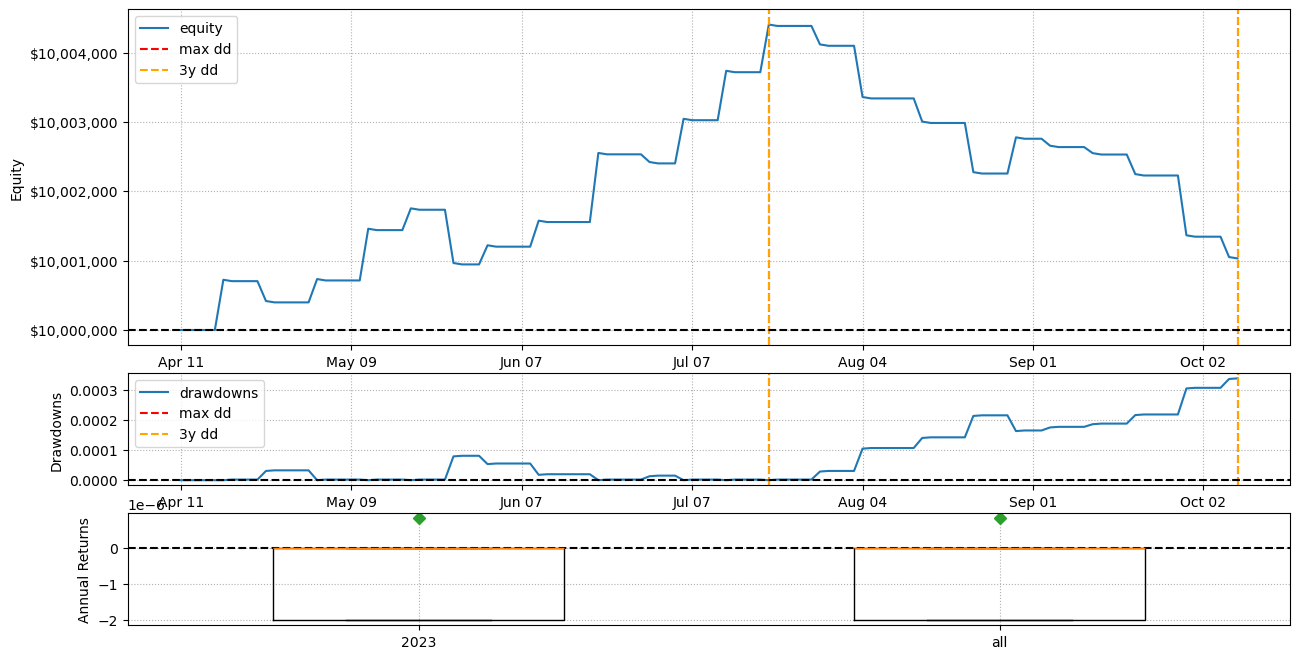

In [22]:
strategy.evaluate_returns(return_metrics=True);

Looks like the strategy needs some further investigating. Anyways, I implemented it with python tws api.

The paper trading bot is a toy example, and doesn't meet requirements for real live trading. The setup is simple, i expect that SPY will be bullish, and buy call spread, when close price is greater than sma. Trade is placed with 30 days to expiration. Things that should be mentioned are:
- we can condition our trade decision on volume and OI
- take greeks into account
- we can use other changepoint detection methods, that are more robust. BOCD depends on hyperparameters of your model and is not robust under outliers.
- algorithm trade only atm options. One possible method is to select best spread in terms of %-age of width. Generally, vertical spreads will become cheaper, as a percentage of the width of the spread, as they get further from at‐the‐money. [([1], p.50)](https://www.amazon.com/Complete-Book-Option-Spreads-Combinations-ebook/dp/B00OCK5P2M)
- we should handle reconnect/error logic 
- add logging for trades, and log trades manually because ib will sometimes send duplicates ids or not send at all

# References

[1] Nations, Scott. The Complete Book of Option Spreads and Combinations: Strategies for Income Generation, Directional Moves, and Risk Reduction (Wiley Trading) 1st Edition, 2014.